In [9]:
# lets build basic rag pipeline


import os
import sys
import argparse


## Retrival Augmented Generation


* 1) Get the document and create indexing, this includes embedding
* 2) project the question into same space
* 3) use semantic search and retrive the neighbours 
* 4) pass this to llm for generation



In [1]:
import json
import os
import spacy
import faiss
from sentence_transformers import SentenceTransformer
# import openai
# from dotenv import load_dotenv
# import re

# load_dotenv()

# openai.api_key = os.getenv("OPENAI_API_KEY")

c:\Users\bkcmk5\Anaconda3\envs\llms\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pypdf 

    

In [4]:
text = pypdf.PdfReader('Numpy_Doc.pdf')



In [5]:
def get_text_from_pdf(pdf_file):
    text = pypdf.PdfReader(pdf_file)
    pages = []
    for page in text.pages:
        pages.append(page.extract_text())
    return pages

In [6]:
pages = get_text_from_pdf('Numpy_Doc.pdf')


NumPy User Guide
Release 1.18.4
Written by the NumPy community
May 24, 2020


In [11]:
print(pages[6])

CHAPTER
ONE
SETTING UP
1.1 What is NumPy?
NumPy is the fundamental package for scientiﬁc computing in Python. It is a Python library that provides a multidi-
mensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for
fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier
transforms, basic linear algebra, basic statistical operations, random simulation and much more.
At the core of the NumPy package, is the ndarray object. This encapsulates n-dimensional arrays of homogeneous
data types, with many operations being performed in compiled code for performance. There are several important
differences between NumPy arrays and the standard Python sequences:
• NumPy arrays have a ﬁxed size at creation, unlike Python lists (which can grow dynamically). Changing the
size of an ndarray will create a new array and delete the original.
• The elements in a NumPy array are a

In [16]:
def chunk_text(text, chunk_size=1):
    chunks = []
    for i in range(0, len(text), chunk_size):
        chunks.append(text[i:i+chunk_size])
    return chunks

In [17]:
chunks = chunk_text(pages)

In [19]:
len(chunks)

170

In [20]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# embeddings = model.encode(sentences, show_progress_bar=True)

# faiss_index = faiss.IndexFlatIP(model.get_sentence_embedding_dimension())
# faiss_index.add(embeddings)

modules.json: 100%|██████████| 349/349 [00:00<00:00, 363kB/s]
c:\Users\bkcmk5\Anaconda3\envs\llms\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\bkcmk5\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
config_sentence_transforme

In [24]:
sentences = [chunk[0] for chunk in chunks]
embeddings = model.encode(sentences, show_progress_bar=True)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches: 100%|██████████| 6/6 [01:55<00:00, 19.20s/it]


In [25]:
embeddings.shape

(170, 768)

In [27]:
# numpy list 
question = "how to create a numpy array"

query_embedding = model.encode(question)

query_embedding.shape

(768,)

In [28]:
model.get_sentence_embedding_dimension()

768

In [29]:
# use the 

faiss_index = faiss.IndexFlatIP(model.get_sentence_embedding_dimension())
faiss_index.add(embeddings)

In [48]:
k = 20
question = "how to define the numpy array?"

query_embedding = model.encode([question])
distances, indices = faiss_index.search(query_embedding, k)

In [49]:
# get document with highest score
print(sentences[indices[0][0]])

NumPy User Guide, Release 1.18.4
2.2.1 An example
>>> import numpy as np
>>>a = np.arange(15).reshape(3, 5)
>>>a
array([[ 0, 1, 2, 3, 4],
[ 5, 6, 7, 8, 9],
[10, 11, 12, 13, 14]])
>>>a.shape
(3, 5)
>>>a.ndim
2
>>>a.dtype.name
'int64'
>>>a.itemsize
8
>>>a.size
15
>>>type(a)
<type 'numpy.ndarray'>
>>>b = np.array([6, 7, 8])
>>>b
array([6, 7, 8])
>>>type(b)
<type 'numpy.ndarray'>
2.2.2 Array Creation
There are several ways to create arrays.
For example, you can create an array from a regular Python list or tuple using the array function. The type of the
resulting array is deduced from the type of the elements in the sequences.
>>> import numpy as np
>>>a = np.array([2,3,4])
>>>a
array([2, 3, 4])
>>>a.dtype
dtype('int64')
>>>b = np.array([1.2, 3.5, 5.1])
>>>b.dtype
dtype('float64')
A frequent error consists in calling array with multiple numeric arguments, rather than providing a single list of
numbers as an argument.
>>>a = np.array(1,2,3,4) # WRONG
>>>a = np.array([1,2,3,4]) # RIGHT
array

In [50]:
indices[0][1:10]

array([ 40,  50,  14,  83, 136,  55, 123, 108,  66], dtype=int64)

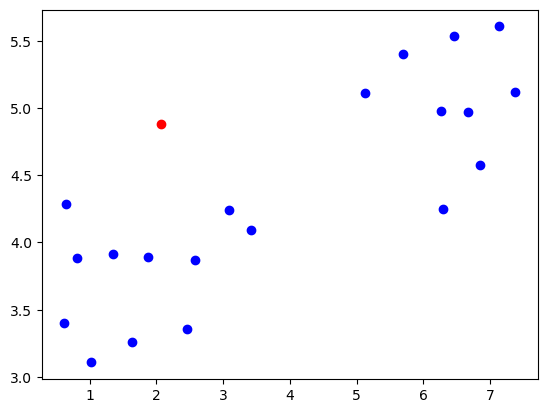

In [51]:
# I want to visualzie the embeddings in 2D space for both the query and top 10 documents

# I will use umap for this

import umap
import matplotlib.pyplot as plt

umap_model = umap.UMAP(n_neighbors=5, metric='cosine')

results_embedding = [embeddings[i] for i in indices[0]]
results_embedding = umap_model.fit_transform(results_embedding)

# query embedding
query_embedding = umap_model.transform(query_embedding)

plt.scatter(query_embedding[0][0], query_embedding[0][1], color='red')
plt.scatter(results_embedding[:, 0], results_embedding[:, 1], color='blue')

plt.show()

In [54]:
from transformers import AutoTokenizer

In [55]:
model_id = "CohereForAI/c4ai-command-r-v01"
tokenizer = AutoTokenizer.from_pretrained(model_id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [57]:


# define conversation input:
conversation = [
    {"role": "user", "content": "Whats the biggest penguin in the world?"}
]
# define documents to ground on:
documents = [
    { "title": "Tall penguins", "text": "Emperor penguins are the tallest growing up to 122 cm in height." }, 
    { "title": "Penguin habitats", "text": "Emperor penguins only live in Antarctica."}
]

# render the tool use prompt as a string:
grounded_generation_prompt = tokenizer.apply_grounded_generation_template(
    conversation,
    documents=documents,
    citation_mode="accurate", # or "fast"
    tokenize='False',
    add_generation_prompt=True,
)
print(grounded_generation_prompt)

[5, 255000, 255008, 10, 29536, 5887, 56584, 206, 2162, 17777, 1709, 2075, 7707, 11600, 4042, 1709, 1690, 7499, 10514, 1728, 3971, 12299, 20008, 21, 5602, 2548, 11205, 8397, 1875, 1955, 39104, 1888, 215549, 21, 206, 206, 10, 5729, 5887, 56584, 206, 1924, 27804, 35913, 206, 5659, 1955, 1671, 13059, 155475, 21024, 19410, 1943, 96213, 1889, 1726, 3153, 3022, 21, 3012, 1955, 89525, 1943, 1671, 3460, 1719, 9468, 19, 1728, 2092, 5854, 1801, 1726, 2789, 1728, 37501, 1690, 7150, 1719, 3172, 9468, 1726, 3349, 3153, 1690, 5161, 21, 3012, 2191, 3815, 1671, 20998, 5824, 3475, 9745, 1728, 1671, 5161, 19, 20499, 1865, 1844, 248218, 1988, 1690, 5161, 21, 3012, 2191, 3118, 3815, 1671, 6452, 23770, 197009, 1933, 3119, 6473, 1719, 6475, 1726, 13897, 21, 5411, 1933, 11205, 1690, 5161, 1914, 14912, 19, 1933, 68755, 2092, 11506, 1709, 2092, 24679, 19, 8250, 1726, 4042, 17777, 21, 206, 206, 10, 13986, 5887, 56584, 206, 1924, 17411, 1728, 29047, 206, 5659, 3153, 3022, 11205, 2313, 8397, 1728, 2543, 14912, 210